In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataset_generation

In [3]:
dataset_generation.SEQ_LEN = 120

In [4]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from theano import sparse
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [5]:
EMB_SIZE = 32

In [6]:
seq_len = theano.shared(dataset_generation.SEQ_LEN)

sequence = sparse.csc_fmatrix('input_seq')
dur_seq = T.fvector('Duration sequence')
d_s_resh = dur_seq.reshape((-1, seq_len))

embedd_w = theano.shared(np.random.normal(0,0.001, (128, EMB_SIZE)))
sequence_embedded = sparse.dot(sequence, embedd_w).reshape((-1, seq_len, EMB_SIZE))



inputs = sequence_embedded[:,:-1]
dur_inps = d_s_resh[:,:-1]

targets = sequence.toarray().reshape((-1,seq_len,128))[:,1:]
dur_targets = d_s_resh[:, 1:]

l_input_sequence = InputLayer(shape=(None, None, EMB_SIZE),input_var=inputs)
l_input_dur_sequence = InputLayer(shape=(None, None),input_var=dur_inps)

In [7]:
from agentnet import Recurrence
from lasagne.layers import *
from agentnet.memory import *
from agentnet.resolver import ProbabilisticResolver

In [8]:
LSTM_SIZE = 100

In [9]:
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)

In [64]:
###One step of rnn
class step:
    
    #inputs
    inp = InputLayer((None, EMB_SIZE),name='current embedded')
    dur_inp = InputLayer((None,),name='current dur')
    
    c_prev = InputLayer((None,LSTM_SIZE),name='previous rnn cell')
    h_prev = InputLayer((None,LSTM_SIZE),name='previous rnn state')
    
    c_new, h_new = LSTMCell(c_prev, h_prev,inp,name="LSTM") 
    
    next_token_probas = DenseLayer(h_new,128,nonlinearity=T.nnet.sigmoid)
    next_token_probas = DenseLayer(next_token_probas,128,nonlinearity=T.nnet.sigmoid)
    
    next_dur_ = DenseLayer(h_new,30,nonlinearity=T.nnet.sigmoid)
    next_dur_ = DenseLayer(next_dur_,1,nonlinearity=T.nnet.softplus)#softplus since durations are positive
    next_dur = ReshapeLayer(next_dur_, (-1,))
    
    #pick next token from predicted probas
    next_token = ExpressionLayer(next_token_probas,
                    lambda probas: T.lt(srng.uniform(size=probas.shape), probas ).astype('float32')
                                )
    next_emb = DenseLayer(next_token, EMB_SIZE, W=embedd_w)

In [65]:
training_loop = Recurrence(
    state_variables={step.h_new:step.h_prev, step.c_new:step.c_prev},
    input_sequences={step.inp:l_input_sequence, step.dur_inp:l_input_dur_sequence},
    tracked_outputs=[step.next_token_probas,step.next_dur],
    unroll_scan=False,
)

/usr/local/lib/python2.7/dist-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=2] State_variables recommended type is OrderedDict.
                Otherwise, order of agent state outputs from get_sessions and get_agent_reaction methods
                may depend on python configuration.

                Current order is: [<lasagne.layers.merge.ElemwiseMergeLayer object at 0x7f01e17e5250>, <lasagne.layers.merge.ElemwiseMergeLayer object at 0x7f01e17e1ed0>]
                You may find OrderedDict in standard collections module: from collections import OrderedDict
                
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [66]:

# Model weights
weights = lasagne.layers.get_all_params(training_loop,trainable=True)

weights+= [embedd_w]
print weights

[LSTM.b_to_ingate, LSTM.W_previous rnn state_to_ingate, LSTM.W_current embedded_to_ingate, LSTM.b_to_forgetgate, LSTM.W_previous rnn state_to_forgetgate, LSTM.W_current embedded_to_forgetgate, LSTM.b_to_cell, LSTM.W_previous rnn state_to_cell, LSTM.W_current embedded_to_cell, LSTM.b_to_outgate, LSTM.W_previous rnn state_to_outgate, LSTM.W_current embedded_to_outgate, LSTM.W_cell_to_ingate_peephole.scales, LSTM.W_cell_to_forgetgate_peephole.scales, LSTM.W_cell_to_outgate_peephole.scales, W, b, W, b, W, b, W, b, W]


In [67]:
predicted_probabilities = lasagne.layers.get_output(training_loop[step.next_token_probas])
predicted_durs = lasagne.layers.get_output(training_loop[step.next_dur])

In [68]:
SKIP_LOSS = theano.shared(20)

In [69]:
#iiinps = {sequence: notes.astype('float32'), dur_seq:durations.astype('float32')} #dbg

In [70]:
#loss_reg.eval(iiinps).shape

In [71]:
from collections import OrderedDict

logprobs = T.log(predicted_probabilities)
neglogprobs = T.log(1 - predicted_probabilities)
durs = predicted_durs.reshape((-1,seq_len - 1))

loss_categ = - targets* logprobs - (1-targets) * neglogprobs#binary crossentropy no need for 
loss_reg = lasagne.objectives.squared_error(dur_targets, durs)

loss = loss_categ.sum(axis=-1).reshape((-1,)) + loss_reg.reshape((-1,))
loss = loss.reshape((-1,seq_len - 1))[:,SKIP_LOSS:].mean()



updates = lasagne.updates.adam(loss,weights)

In [72]:
upds = OrderedDict()

In [73]:
for u in updates:
    upds[u] = updates[u].clip(-1,1)
    pass

In [41]:
#training
train_step = theano.function([sequence, dur_seq], [loss_categ, loss_reg],
                             updates=training_loop.get_automatic_updates()+upds, allow_input_downcast=True)

In [74]:
get_output_shape(step.next_dur)

(None,)

In [75]:
n_steps = T.scalar(dtype='int32')
feedback_loop = Recurrence(
    state_variables={step.h_new:step.h_prev, step.c_new:step.c_prev, 
                     step.next_emb:step.inp, step.next_dur:step.dur_inp},
    tracked_outputs=[step.next_token_probas,step.next_dur, step.next_token],
    batch_size=theano.shared(1),
    n_steps=n_steps,
    unroll_scan=False,
)

/usr/local/lib/python2.7/dist-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=2] State_variables recommended type is OrderedDict.
                Otherwise, order of agent state outputs from get_sessions and get_agent_reaction methods
                may depend on python configuration.

                Current order is: [<lasagne.layers.shape.ReshapeLayer object at 0x7f01e17e5ed0>, <lasagne.layers.dense.DenseLayer object at 0x7f01e17ea150>, <lasagne.layers.merge.ElemwiseMergeLayer object at 0x7f01e17e5250>, <lasagne.layers.merge.ElemwiseMergeLayer object at 0x7f01e17e1ed0>]
                You may find OrderedDict in standard collections module: from collections import OrderedDict
                
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [76]:
generated_tokens, generated_durs = get_output(feedback_loop[step.next_token, step.next_dur])

generated_music = T.stack([generated_tokens[0],generated_durs[0].reshape((-1,1))], axis=1)

In [77]:
generate_sample = theano.function([n_steps],[generated_tokens[0], generated_durs[0]],updates=feedback_loop.get_automatic_updates(),allow_input_downcast=True)

In [78]:
def gen_music(n_steps = dataset_generation.SEQ_LEN):
    tok, durss = generate_sample(n_steps)
    return np.hstack([tok,np.abs(durss.reshape((-1,1)))])

In [80]:
from midi_preproc import save_mat2_mid
save_mat2_mid(gen_music(500))

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
categ_hist = []
reg_hist = []

In [111]:
dataset_generation.SEQ_LEN = 170
seq_len.set_value(dataset_generation.SEQ_LEN)

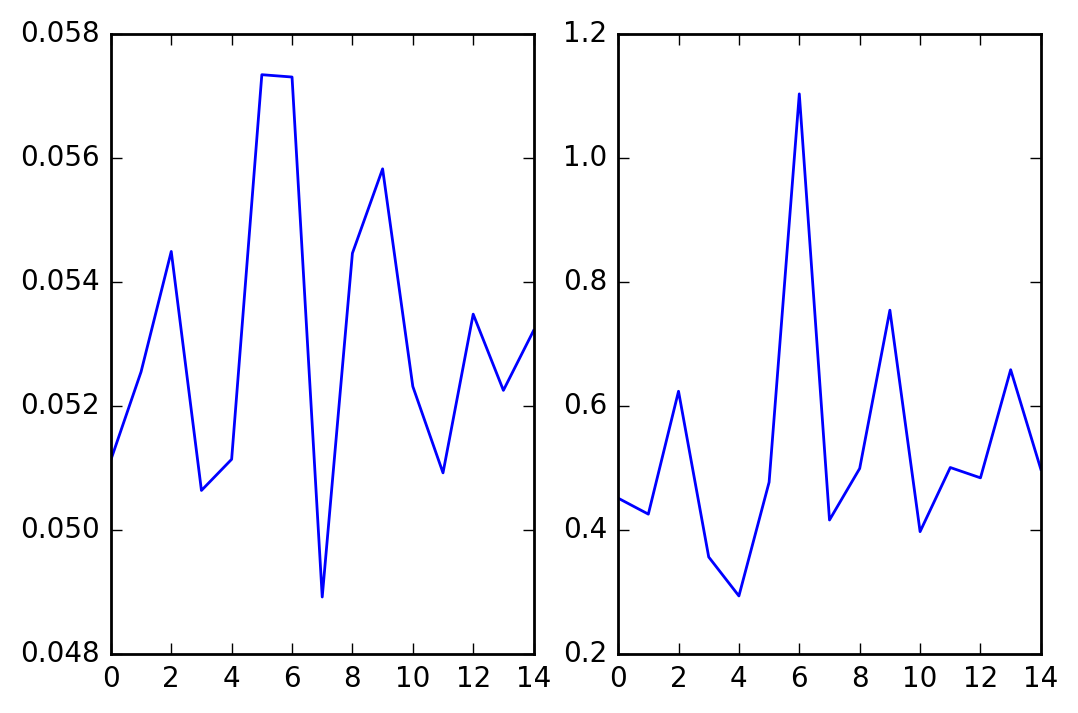

KeyboardInterrupt: 

In [112]:
from IPython.display import clear_output

#train loop
t = tqdm_notebook(dataset_generation.iterate_minibatches(1000, 1000), total = 1000)



it = 1
for batch in t:
    notes = batch[:,:-1]
    durations = np.array( batch[:,-1].todense()).ravel()
    categ, reg = train_step(notes, durations)
    categ_hist.append(categ.mean())
    reg_hist.append(reg.mean())
    it+=1
    if it%1 == 0:
        clear_output()
        
        plt.subplot(1,2,1)
        plt.plot(categ_hist[-15:])
        plt.subplot(1,2,2)
        plt.plot(reg_hist[-15:])
        plt.show()

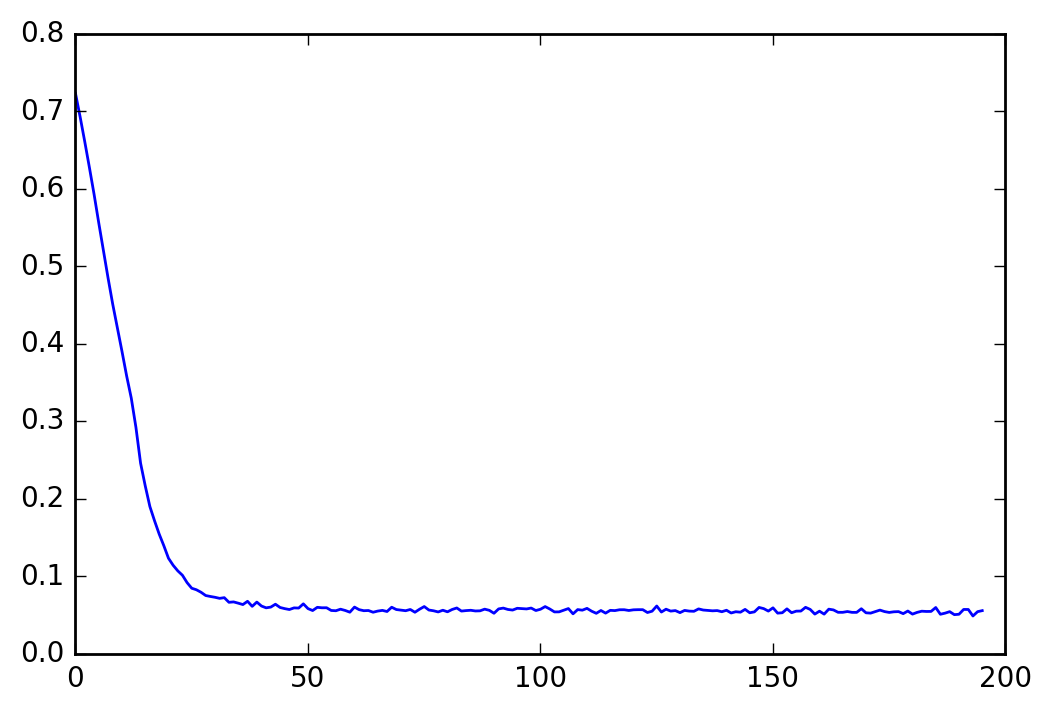

In [110]:
plt.plot(categ_hist)

In [60]:
import pickle as pkl

In [113]:
with open('params.pkl','wb') as f:
    for w in weights:
        pkl.dump(w.get_value(), f)

In [79]:
with open('params.pkl','rb') as f:
    for w in weights:
        w.set_value(pkl.load( f))